## CIFAR10图片分类
### 从头train一个resnet18

In [1]:
import torch
import torchvision
from torch import nn
import torchvision.transforms as T
import os
import shutil
import collections
import math
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from d2l import torch as d2l

data_dir = '../data/cifar-10'

def read_csv_labels(fname):
    with open(fname, 'r') as f:
        # 按行读取，返回一个列表，列表中一个元素是文件中的一行
        lines = f.readlines()[1:]
    # 去掉换行符\n并按照','分隔，每行返回一个列表，列表嵌套列表
    tokens = [l.rstrip().split(',') for l in lines]
    return dict((name, label) for name, label in tokens)

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('number of samples:\t',len(labels))
print('classes \t', len(set(labels.values())))
# labels

number of samples:	 50000
classes 	 10


In [2]:
# 定义函数，把源文件夹的文件复制到目标文件夹
def copyfile(filename, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
    # 训练集中样本最少种类的数量
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # 验证机中每个类别的样本数
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train', label))
    return n_valid_per_label

def reorg_test(data_dir):
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file), 
                 os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

In [3]:
# 重新组织cifar10的数据结构
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)


valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

- 图像增广

In [4]:
train_transform = T.Compose([
    T.Resize(40),
    T.RandomResizedCrop(32, scale=(0.64, 1), ratio=(1.0, 1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(
        [0.4919, 0.4822, 0.4465],
        [0.2023, 0.1994, 0.2010]
    )
])

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        [0.4919, 0.4822, 0.4465],
        [0.2023, 0.1994, 0.2010]
    )
])

- 读取数据集和dataloader

In [27]:
batch_size = 128 if len(d2l.try_all_gpus()) > 1 else 64
train_ds, train_valid_ds = [ImageFolder(os.path.join(data_dir, 'train_valid_test', folder), 
                                        transform=train_transform) for folder in ['train', 'train_valid']]
valid_ds, test_ds = [ImageFolder(os.path.join(data_dir, "train_valid_test", folder), 
                                 transform=test_transform) for folder in ['valid', 'test']]
# init the dataloader
train_iter, train_valid_iter = [DataLoader(dataset, batch_size, shuffle=True,)
                                for dataset in [train_ds, train_valid_ds]]
valid_iter, test_iter = [DataLoader(dataset, batch_size, shuffle=False,)
                         for dataset in [valid_ds, test_ds]]

- 定义模型

In [6]:
def get_net():
    net = d2l.resnet18(10, 3)
    return net

loss = nn.CrossEntropyLoss(reduction='none')

In [9]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr, momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend)
    if len(devices) > 1:
        net = nn.DataParallel(net, devices).to(devices[0])
    else:
        net = net.to(*devices)
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if i % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, 
                             (metric[0] / metric[2], metric[1]/ metric[2], None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

train loss 0.207, train acc 0.927, valid acc 0.790
2743.2 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


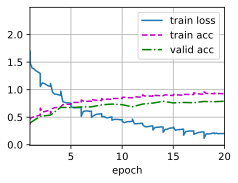

In [12]:
lr_period = 4
lr_decay = 0.9
net = get_net()
devices = d2l.try_all_gpus()
num_epochs = 20
lr = 2e-4
wd = 5e-4
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)
# devices

- 把所有数据集放在一起train一遍

train loss 0.046, train acc 0.984
2358.0 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


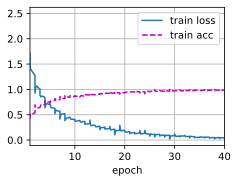

In [14]:
net, preds = get_net(), []
num_epochs = 40
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)


In [38]:
torch.save(net, 'resnet18.pth')

In [36]:
preds = []
for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())

In [37]:
import pandas as pd
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x:str(x))
df = pd.DataFrame({'id':sorted_ids, 'label':preds})
df['label'] = df['label'].apply(lambda x:train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)
# len(preds), len(sorted_ids)